## Exploring Decision Tree Classifiers using [German Credit Data from UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)

#### Analysis follows Chapter 5 of *Machine Learning with R* by Brett Lantz (though of course here we use Python, not R)

#### Objective:  Use a decision tree to predict whether a user will default on a credit loan based on quantitive data about the loan and the borrower, using accuracy as  the metric.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_graphviz
import graphviz

warnings.filterwarnings("ignore")
%matplotlib
sns.set(style="white", color_codes=True)

Using matplotlib backend: MacOSX


### 1. Import data into pandas dataframe

In [2]:
#data from https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29
data = pd.read_csv('german.data.txt', delim_whitespace=True, header=None)

### 2. Basic data exploration and transformation

In [3]:
data.head(6)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1


In [4]:
data.shape

(1000, 21)

In [5]:
data[11].value_counts()

A123    332
A121    282
A122    232
A124    154
Name: 11, dtype: int64

In [6]:
#these columns have a continuous range of values, and should not be aggregated
skip = [1,4,12,20]
#the column values are strings, and need to be floats to fit the model
le = LabelEncoder()
for i in range(data.shape[1]):
    if i in skip:
        continue
    data.iloc[:,i] = le.fit_transform(data.iloc[:,i])


In [7]:
data.rename(columns={20:"Default"}, inplace=True)

In [8]:
def default_text(code):
    if code == 1:
        return 'No'
    elif code == 2:
        return 'Yes'
    else:
        return code
    
Y = data['Default'].apply(default_text)
X = data.drop('Default', axis=1)


In [9]:
data['Default'].value_counts()

1    700
2    300
Name: Default, dtype: int64

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=372)

In [11]:
X_train.shape

(700, 20)

In [12]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,700.0,1.578571,1.259402,0.0,0.0,1.0,3.0,3.0
1,700.0,21.045714,12.168379,4.0,12.0,18.0,24.0,72.0
2,700.0,2.550000,1.085244,0.0,2.0,2.0,4.0,4.0
3,700.0,3.282857,2.743178,0.0,1.0,3.0,4.0,9.0
4,700.0,3299.664286,2855.580613,276.0,1386.0,2333.0,3951.5,18424.0
5,700.0,1.137143,1.599729,0.0,0.0,0.0,2.0,4.0
6,700.0,2.355714,1.202303,0.0,2.0,2.0,3.0,4.0
7,700.0,1.997143,1.109198,0.0,1.0,2.0,3.0,3.0
8,700.0,1.698571,0.713049,0.0,1.0,2.0,2.0,3.0
9,700.0,0.148571,0.482229,0.0,0.0,0.0,0.0,2.0


In [13]:
Y_test.value_counts()

No     196
Yes    104
Name: Default, dtype: int64

In [14]:
Y_train.value_counts()

No     504
Yes    196
Name: Default, dtype: int64

### 3. Create a decision tree classifier

In [15]:
#weights =  [{'No': 1, 'Yes': 1}]
model = DecisionTreeClassifier(max_depth=None, criterion='entropy')
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [16]:
#from scikit-learn website:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, predictions)

# Plot Z-scaled confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Default','Default'])                                      
plt.show()

Confusion matrix, without normalization
[[160  36]
 [ 56  48]]


In [17]:
print('The accuracy is {0:.1f}%'.format(100*accuracy_score(Y_test, predictions)))

The accuracy is 69.3%


In [19]:
export_graphviz(model, out_file="mytree.dot", feature_names = X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
# too big to display
#graphviz.Source(dot_graph)

### 4. Optimize parameters

In [20]:
def GridSearchCV_results( classifier_list, X, y, score ):
    '''
    Runs the GridSearchCV function on given inputs
    Output: dictionary where key = tuple of parameters, value = score
    '''
    results = {}

    for c in classifier_list:
        
        pipeline = Pipeline([ (c[0], c[1]) ])

        parameters = {}

        parameters.update(c[2])

        grid_search = GridSearchCV(pipeline, parameters, scoring=score, verbose=0, n_jobs=4)

        results[(c[0])] = grid_search.fit(X,y)
        
    return results

In [21]:
classifier_list = [
    ('dtc', DecisionTreeClassifier(), 
    {'dtc__criterion': ('gini', 'entropy'),        
    'dtc__min_samples_split':(3, 5, 10, 20, 50, 100),
    'dtc__max_depth':(2, 3, 4, 5, 6, 7, 8, 9, 10)})
]
results = GridSearchCV_results( classifier_list, X_train, Y_train, score = 'accuracy' )

In [22]:
res = pd.DataFrame(results[('dtc')].cv_results_)
res.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_dtc__criterion,param_dtc__max_depth,param_dtc__min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
28,0.003338,0.000747,0.730000,0.809996,gini,6,50,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",1,0.739316,0.804721,0.712446,0.820128,0.738197,0.805139,0.001134,0.000051,0.012407,0.007167
42,0.003227,0.000721,0.730000,0.931439,gini,9,3,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",1,0.760684,0.946352,0.699571,0.918630,0.729614,0.929336,0.000332,0.000013,0.024960,0.011415
20,0.003236,0.000710,0.727143,0.825710,gini,5,10,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",3,0.717949,0.819742,0.716738,0.835118,0.746781,0.822270,0.000954,0.000017,0.013880,0.006732
70,0.002495,0.000697,0.727143,0.772843,entropy,4,50,"{'dtc__criterion': 'entropy', 'dtc__min_sample...",3,0.730769,0.753219,0.725322,0.794433,0.725322,0.770878,0.000159,0.000003,0.002570,0.016883
34,0.004128,0.000708,0.724286,0.816426,gini,7,50,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",5,0.726496,0.813305,0.712446,0.820128,0.733906,0.815846,0.000608,0.000008,0.008893,0.002816


In [23]:
model = DecisionTreeClassifier(max_depth=6, criterion='gini', min_samples_split=50)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [24]:
print('The accuracy is {0:.1f}%'.format(100*accuracy_score(Y_test, predictions)))

The accuracy is 68.0%


 Almost 1% less than before.

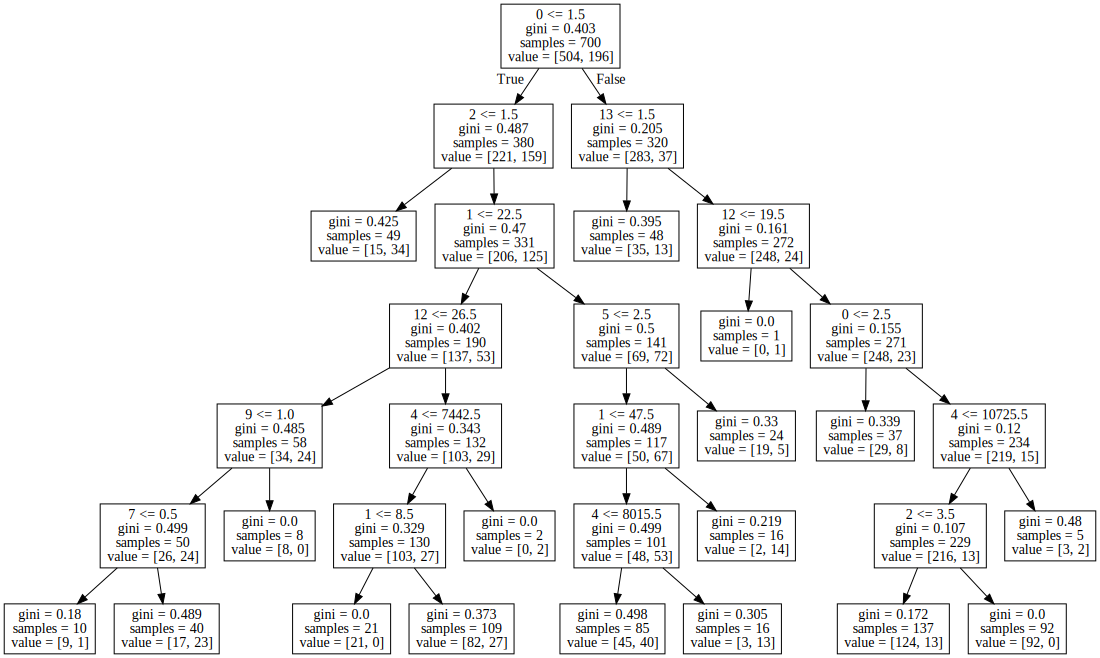

In [25]:
export_graphviz(model, out_file="mytree.dot", feature_names = X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 5. Try AdaBoost

In [26]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, criterion='gini', min_samples_split=50),n_estimators=30)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [27]:
print('The accuracy is {0:.1f}%'.format(100*accuracy_score(Y_test, predictions)))

The accuracy is 69.7%


Slightly better...

### 6. Try a Random Forest

In [28]:
classifier_list = [
    ('rfc', RandomForestClassifier(), 
    {'rfc__n_estimators': (2, 5, 10, 30, 50),
     'rfc__max_features': (2, 5, 10, 20),
    'rfc__criterion': ('gini', 'entropy'),        
    'rfc__min_samples_split':(3, 5, 10, 20, 50, 100),
    'rfc__max_depth':(2, 3, 4, 5, 6, 7, 8, 9, 10)})
]
rf_results = GridSearchCV_results( classifier_list, X_train, Y_train, score = 'accuracy' )

In [29]:
res = pd.DataFrame(rf_results[('rfc')].cv_results_)
res.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_rfc__criterion,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_split,param_rfc__n_estimators,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1969,0.095961,0.006335,0.797143,0.870005,entropy,9,5,20,50,"{'rfc__max_features': 5, 'rfc__min_samples_spl...",...,0.799145,0.877682,0.798283,0.877944,0.793991,0.854390,0.001839,0.000265,0.002254,0.011043
2113,0.099832,0.006385,0.797143,0.928576,entropy,10,10,10,30,"{'rfc__max_features': 10, 'rfc__min_samples_sp...",...,0.799145,0.935622,0.802575,0.914347,0.789700,0.935760,0.011696,0.003042,0.005441,0.010062
1724,0.106723,0.007163,0.797143,0.884289,entropy,7,5,10,50,"{'rfc__max_features': 5, 'rfc__min_samples_spl...",...,0.811966,0.888412,0.793991,0.890792,0.785408,0.873662,0.015176,0.001528,0.011072,0.007577
679,0.099591,0.005802,0.795714,0.875719,gini,7,10,20,50,"{'rfc__max_features': 10, 'rfc__min_samples_sp...",...,0.807692,0.881974,0.789700,0.877944,0.789700,0.867238,0.004064,0.000015,0.008488,0.006219
1623,0.067738,0.003921,0.795714,0.900718,entropy,6,10,3,30,"{'rfc__max_features': 10, 'rfc__min_samples_sp...",...,0.794872,0.905579,0.793991,0.905782,0.798283,0.890792,0.005955,0.000076,0.001850,0.007019


Again, make test predictions using the optimal parameters.

In [30]:
model = RandomForestClassifier(max_depth=9, criterion='gini', max_features=20, min_samples_split=10,n_estimators=50)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [31]:
print('The accuracy is {0:.1f}%'.format(100*accuracy_score(Y_test, predictions)))

The accuracy is 73.0%


The best yet.

### 7. Summary

The decision tree classifier can predict defaults with about 68-69% accuracy.  This goes up to 69.7% using AdaBoost.

The optimized random forest accuracy is slightly better at 73%.

The following parameters were explored:

Classifiers:
- Decision Tree
- AdaBoost (with Decision Trees)
- Random Forest

Decision Tree:
- split criteria (gini was best)
- minimum number of samples to allow a split (50 was best)
- maximum tree depth (6 was best)

Random Forest:
- split criteria (gini was best)
- minimum number of samples to allow a split (10 was best)
- maximum tree depth (9 was best)
- number of features to choose from (10 was best)
- number of trees in the forest (50 was best)

